In [95]:
import pandas as pd
import numpy as np

In [96]:
df = pd.read_csv("titanic.csv", index_col="PassengerId")
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,Mr. Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,Mrs. John Bradley (Florence Briggs Thayer),female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,Miss. Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,Mrs. Jacques Heath (Lily May Peel),female,35.0,1,0,113803,53.1000,C123,S
5,0,3,Mr. William Henry,male,35.0,0,0,373450,8.0500,NaN,S


In [97]:
X = df.drop(columns="Survived")
y = df["Survived"]

In [98]:
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_selector
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
sklearn.set_config(display="diagram")

In [99]:
def extract_title(series):
    # df["Name"].str.split(",").str[1].str.split().str[0]
    return series.apply(lambda x:x.split(".")[0]).to_frame()

In [100]:
title_extractor = FunctionTransformer(extract_title)
title_extractor


FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)

In [101]:
title_extractor.fit_transform(df["Name"]).head(3)

,Name
PassengerId,
1,Mr
2,Mrs
3,Miss


In [102]:
ColumnTransformer([
    ("functiontransformer", title_extractor, "Name")
])

ColumnTransformer(transformers=[('functiontransformer',
                                 FunctionTransformer(func=<function extract_title at 0x7fab974753a0>),
                                 'Name')])

In [103]:
def extract_deck(series):
    return series.str[0].to_frame()

In [104]:
deck_extractor = FunctionTransformer(extract_deck)
deck_extractor 

FunctionTransformer(func=<function extract_deck at 0x7fab972aa940>)

In [105]:
deck_extractor.fit_transform(df["Cabin"]).head(3)

,Cabin
PassengerId,
1,NaN
2,C
3,NaN


In [106]:
deck_pipeline = make_pipeline(
    deck_extractor,
    SimpleImputer(strategy="constant", fill_value="U"),
    OneHotEncoder(handle_unknown="ignore"),
)

In [107]:
numerical_pipeline = make_pipeline(
    StandardScaler(), SimpleImputer(strategy="median")
)

In [108]:
ct = make_column_transformer(
    (make_pipeline(title_extractor, OneHotEncoder(handle_unknown="ignore")), "Name"), 
    (deck_pipeline, "Cabin"),
    (OneHotEncoder(handle_unknown="ignore"), ["Sex"]), 
    (numerical_pipeline, make_column_selector(dtype_include="number"))
)
ct

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 'Name'),
                                ('pipeline-2',
                                 Pipeline(steps=[('functiontransformer',
                                                  FunctionTransformer(func=<function extract_deck at 0x7fab972aa940>)),
                                                 ('simpleimpu...
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 'Cabin'),
                                ('onehotencoder',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['Sex']),
                                ('pipeline-3',
                                 Pipeline(steps=[('standardscaler',
                                                  StandardScaler()),
                                                 ('simpleimputer',
                                                  SimpleImputer(strategy='median'))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7fab971232e0>)])

In [109]:
clf = make_pipeline(ct, LogisticRegression())
clf

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Name'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract...
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Cabin'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fab971232e0>)])),
                ('logisticregression', LogisticRegression())])

In [110]:
clf.fit(X, y)
clf.predict(X)

scores = cross_val_score(clf, X, y)
scores.mean()

0.8215429037725188

We know that the Logistic Regression is highly affected by unscaled variables, giving convergence warnings. But is it the same for the Random Forest? Using a GridSearchCV, compare the result of having a StandardScaler, RobustScaler, or "passthrough". Combine that with a sensible range of values for n_estimators using np.linspace. What is your best combination?

In [111]:
from sklearn.ensemble import RandomForestClassifier

In [112]:
clf = make_pipeline(ct, RandomForestClassifier())

In [113]:
param_grid = [{
    "columntransformer__pipeline-3__standardscaler": [StandardScaler(),RobustScaler(),"passthrough"],
    "randomforestclassifier__n_estimators": np.linspace(10,500,39).astype(int)
}]
param_grid

[{'columntransformer__pipeline-3__standardscaler': [StandardScaler(),
   RobustScaler(),
   'passthrough'],
  'randomforestclassifier__n_estimators': array([ 10,  22,  35,  48,  61,  74,  87, 100, 113, 126, 138, 151, 164,
         177, 190, 203, 216, 229, 242, 255, 267, 280, 293, 306, 319, 332,
         345, 358, 371, 383, 396, 409, 422, 435, 448, 461, 474, 487, 500])}]

In [114]:
gs = GridSearchCV(clf, param_grid, n_jobs=-1)
gs.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         'Name'),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransforme...
                                       ('randomforestclassifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid=[{'columntransformer__pipeline-3__standardscaler': [StandardScaler(),
                                                                            RobustScaler(),
                                                                            'passthrough'],
                          'randomforestclassifier__n_estimators': array([ 10,  22,  35,  48,  61,  74,  87, 100, 113, 126, 138, 151, 164,
       177, 190, 203, 216, 229, 242, 255, 267, 280, 293, 306, 319, 332,
       345, 358, 371, 383, 396, 409, 422, 435, 448, 461, 474, 487, 500])}])

In [115]:
gs.best_score_

0.826062394074446

In [116]:
results = pd.DataFrame(gs.cv_results_).sort_values("rank_test_score")
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_columntransformer__pipeline-3__standardscaler,param_randomforestclassifier__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
102,1.284177,0.017900,0.090654,0.019647,passthrough,319,{'columntransformer__pipeline-3__standardscale...,0.804469,0.797753,0.882022,0.758427,0.887640,0.826062,0.050528,1
55,0.856557,0.011127,0.064434,0.009157,RobustScaler(),216,{'columntransformer__pipeline-3__standardscale...,0.815642,0.797753,0.870787,0.764045,0.882022,0.826050,0.044470,2
83,0.389135,0.030599,0.041728,0.003699,passthrough,74,{'columntransformer__pipeline-3__standardscale...,0.815642,0.797753,0.876404,0.764045,0.870787,0.824926,0.043091,3
103,1.309186,0.037202,0.092150,0.013358,passthrough,332,{'columntransformer__pipeline-3__standardscale...,0.798883,0.803371,0.882022,0.752809,0.882022,0.823821,0.050710,4
48,0.564080,0.033902,0.059451,0.003003,RobustScaler(),126,{'columntransformer__pipeline-3__standardscale...,0.815642,0.797753,0.882022,0.747191,0.876404,0.823803,0.050539,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32,1.960754,0.017576,0.109921,0.010318,StandardScaler(),422,{'columntransformer__pipeline-3__standardscale...,0.798883,0.786517,0.865169,0.741573,0.870787,0.812586,0.049117,112
2,0.163610,0.002852,0.025555,0.001616,StandardScaler(),35,{'columntransformer__pipeline-3__standardscale...,0.804469,0.769663,0.853933,0.769663,0.859551,0.811456,0.039139,114
0,0.086944,0.005320,0.025860,0.004031,StandardScaler(),10,{'columntransformer__pipeline-3__standardscale...,0.782123,0.797753,0.870787,0.764045,0.837079,0.810357,0.038644,115
12,0.805290,0.023938,0.060838,0.002392,StandardScaler(),164,{'columntransformer__pipeline-3__standardscale...,0.804469,0.786517,0.865169,0.735955,0.859551,0.810332,0.048089,116


In [119]:
n_estimator_results = results[[
    "param_randomforestclassifier__n_estimators",
    "mean_test_score",
    "param_columntransformer__pipeline-3__standardscaler"
]].rename(columns={
    "param_randomforestclassifier__n_estimators": "n_nestimators",
    "param_columntransformer__pipeline-3__standardscaler": "scaler"
}).dropna()

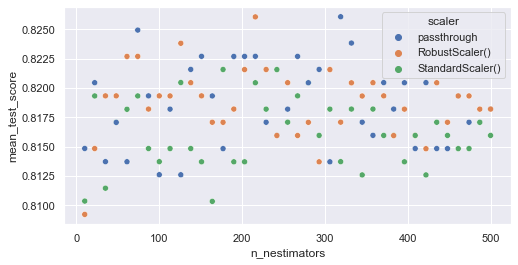

In [122]:
plt.figure(figsize =(8,4))

sns.scatterplot(
    x=n_estimator_results["n_nestimators"],
    y=n_estimator_results ["mean_test_score"],
    hue=n_estimator_results["scaler"]
)
plt.show()

SVC (Support Vector Classification) is one of the classifiers recommended by scikit-learn in their "choosing the right estimator" chart. Using a GridSearchCV, sweep a sensible range of values for C and gamma, using np.logspace. What is your best combination?

In [123]:
from sklearn.svm import SVC

In [124]:
clf2 = make_pipeline(ct, SVC())
clf2

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Name'),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('functiontransformer',
                                                                   FunctionTransformer(func=<function extract...
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  'Cabin'),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Sex']),
                                                 ('pipeline-3',
                                                  Pipeline(steps=[('standardscaler',
                                                                   StandardScaler()),
                                                                  ('simpleimputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7fab971232e0>)])),
                ('svc', SVC())])

In [150]:
param_grid2 = [{
    "svc__C": np.logspace(np.log10(0.05), np.log10(10.0),10),
    "svc__gamma": np.logspace(np.log10(0.05), np.log10(1.0),10)
}]
param_grid2

[{'svc__C': array([ 0.05      ,  0.09008241,  0.16229682,  0.29240177,  0.52680514,
          0.94911755,  1.70997595,  3.08077514,  5.55047308, 10.        ]),
  'svc__gamma': array([0.05      , 0.06974754, 0.09729439, 0.13572088, 0.18932395,
         0.2640976 , 0.36840315, 0.51390427, 0.71687116, 1.        ])}]

In [151]:
gs2 = GridSearchCV(clf2, param_grid2, n_jobs=-1)
gs2.fit(X,y)

GridSearchCV(estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('pipeline-1',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransformer(func=<function extract_title at 0x7fab974753a0>)),
                                                                                         ('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         'Name'),
                                                                        ('pipeline-2',
                                                                         Pipeline(steps=[('functiontransformer',
                                                                                          FunctionTransforme...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7fab971232e0>)])),
                                       ('svc', SVC())]),
             n_jobs=-1,
             param_grid=[{'svc__C': array([ 0.05      ,  0.09008241,  0.16229682,  0.29240177,  0.52680514,
        0.94911755,  1.70997595,  3.08077514,  5.55047308, 10.        ]),
                          'svc__gamma': array([0.05      , 0.06974754, 0.09729439, 0.13572088, 0.18932395,
       0.2640976 , 0.36840315, 0.51390427, 0.71687116, 1.        ])}])

In [152]:
gs2.best_score_

0.8383842822170612

In [153]:
results2 = pd.DataFrame(gs2.cv_results_).sort_values("rank_test_score")
results2

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
90,0.047710,0.001719,0.017601,0.002995,10.0,0.05,"{'svc__C': 10.0, 'svc__gamma': 0.0499999999999...",0.837989,0.825843,0.831461,0.825843,0.870787,0.838384,0.016808,1
81,0.048096,0.003771,0.017098,0.002254,5.550473,0.069748,"{'svc__C': 5.550473077848112, 'svc__gamma': 0....",0.837989,0.820225,0.837079,0.825843,0.870787,0.838384,0.017543,2
72,0.048262,0.002094,0.016487,0.001916,3.080775,0.097294,"{'svc__C': 3.0807751387916715, 'svc__gamma': 0...",0.832402,0.820225,0.837079,0.825843,0.865169,0.836143,0.015600,3
52,0.048223,0.001664,0.015705,0.000736,0.949118,0.097294,"{'svc__C': 0.9491175455796848, 'svc__gamma': 0...",0.843575,0.825843,0.825843,0.808989,0.870787,0.835007,0.020969,4
61,0.049975,0.002756,0.019360,0.001573,1.709976,0.069748,"{'svc__C': 1.7099759466766964, 'svc__gamma': 0...",0.843575,0.825843,0.825843,0.808989,0.870787,0.835007,0.020969,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,0.058877,0.010508,0.025331,0.002349,0.090082,1.0,"{'svc__C': 0.09008241153272054, 'svc__gamma': ...",0.670391,0.719101,0.814607,0.752809,0.831461,0.757674,0.059692,96
18,0.047334,0.001779,0.020773,0.004084,0.090082,0.716871,"{'svc__C': 0.09008241153272054, 'svc__gamma': ...",0.681564,0.719101,0.775281,0.764045,0.831461,0.754290,0.051026,97
8,0.056894,0.008055,0.022645,0.005795,0.05,0.716871,"{'svc__C': 0.049999999999999996, 'svc__gamma':...",0.754190,0.814607,0.775281,0.752809,0.674157,0.754209,0.045830,98
29,0.048847,0.002391,0.019491,0.001274,0.162297,1.0,"{'svc__C': 0.16229681735100848, 'svc__gamma': ...",0.692737,0.713483,0.764045,0.747191,0.814607,0.746413,0.042255,99


In [154]:
svc_results = results2[[
    "param_svc__C",
    "mean_test_score",
    "param_svc__gamma"
]].rename(columns={
    "param_svc__C": "C",
    "param_svc__gamma": "gamma"
}).dropna()

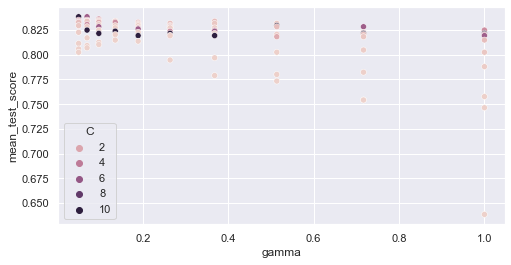

In [183]:
plt.figure(figsize =(8,4))

sns.scatterplot(
    x=svc_results["gamma"],
    y=svc_results["mean_test_score"],
    hue=svc_results["C"],
)

plt.show()